# Corn Disease Detection Based On Leaf Photos
Sebuah AI untuk mendeteksi penyakit pada tanaman jagung berdasarkan foto daunnya. AI ini menggunakan dataset dari kaggle pada link berikut : https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset

Sebelum menggunakan dataset tersebut, kami melakukan tahap data exploration dan preparation terlebih dahulu. Data berupa data gambar berjumlah 4188 yang dibagi kedalam 4 class, berikut adalah class yang ada pada dataset :
- Common Rust - 1306 images
- Gray Leaf Spot - 574 images
- Blight -1146 images
- Healthy - 1162 images

Pada tahap preparation data, kami melakukan tahapan sebagai berikut :
- Resize -> Mengatur ukuran gambar agar semua gambar mempunyai ukuran yang sama yaitu 224x224 px.
- Normalize -> Membagi ukuran pixel dengan 255 agar ukuran pixel berskala 0-1, ini akan memudahkan model machine learning untuk melakukan training nantinya.
- Augmentation -> Menambahkan ragam dan variasi foto.
- Splitting data -> Membagi data menjadi 80% untuk training dan 20% untuk testing

Model yang digunakan pada AI ini adalah CNN(Convolutional Neural Network), mengapa kami menggunakan model ini? Karena model CNN adalah model yang mampu melakukan pengenalan dan pemrosesan gambar. Umumnya model ini digunakan untuk Object detection, image classification, face recognition, dsb yang berhubungan dengan gambar.



## Preparation


### Dataset Path
menetepakan path untuk menuju drive dimana dataset disimpan.

gray_leaf_spot dan augmented_gray_leaf_spot adalah path yang dibuat untuk melakukan data augmentasi khusus untuk class Gray Leaf Spot Saja.

In [ ]:
data_path = 'corn_disease2'
data_path_bfr_augmented = 'corn_disease'
# gray_leaf_spot = 'corn_disease/Gray_Leaf_Spot'
# augmented_gray_leaf_spot = 'corn_disease/Augmented_Gray_Leaf_Spot'

### Import Libraries
Mengimport library yang dibutuhkan untuk kebutuhan preparation dan modelling data

In [ ]:
import numpy as np
import os
import cv2
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Preparation Data

### Resize Image
mengubah semua ukuran gambar menjadi 224x224 pixel agar semua gambar memiliki ukuran yang sama.

In [5]:
IMG_SIZE = (224, 224)

### Load Images & Labels
Memuat gambar dan label dari dataset yang ada.

In [6]:
# Load images and labels
def load_images(data_path, img_size):
    images = []
    labels = []
    for label in os.listdir(data_path):
        class_dir = os.path.join(data_path, label)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)  # Resize to target size
                images.append(img)
                labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [7]:
images, labels = load_images(data_path, IMG_SIZE)

### Splitting Data
Membagi data yang ada menjadi 80% untuk training dan 20% untuk testing.

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

### Normalize
Membagi nilai pixel dengan 255 agar nilai pixel berskala antara 0-1 sehingga memudahkan kerja model nantinya.

In [9]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### Visualize Data
Memvisualisasikan jumlah data masing-masing kelas menggunakan bar plot. Data yang ditunjukkan adalah data yang sudah dibersihkan secara manual sebelumnya, seperti menghapus gambar yang blur, gambar yang tidak sesuai dengan class nya, dsb.

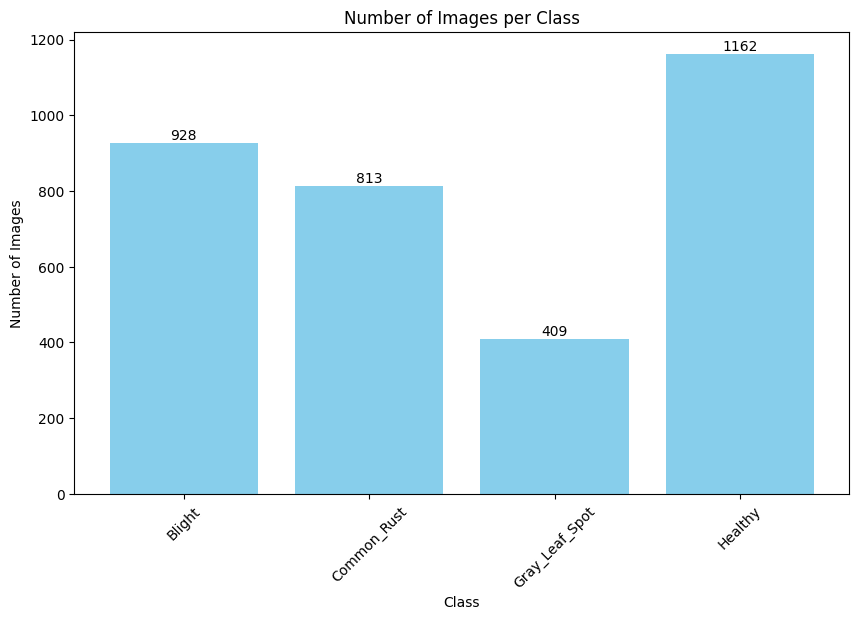

In [18]:
class_names = os.listdir(data_path_bfr_augmented)
class_counts = []

# Count the number of images in each class
for class_name in class_names:
    class_folder = os.path.join(data_path_bfr_augmented, class_name)
    num_images = len(os.listdir(class_folder))
    class_counts.append(num_images)

# Plotting the results
plt.figure(figsize=(10, 6))
bars=plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=10)

plt.show()

### Augmentation for Gray Leaf Spot Class
Mengapa melakukan data augmentasi khusus untuk class gray leaf spot? karena data pada class gray leaf spot hanya berjumlah 409 sedangkan kelas lainnya berjumlah 2 kali lipat bahkan lebih dari class gray leaf spot. Hal ini akan meningkatkan prediksi dan akurasi pada class gray leaf spot nantinya.

#### Count the Need of Augmentation
Menghitung kebutuhan data yang diperlukan untuk augmentasi.

In [ ]:
# target_num_images = 800  # Target number of images to match other classes
# current_num_images = len(os.listdir(gray_leaf_spot))
# images_needed = target_num_images - current_num_images
# print(images_needed)

391


#### Augmentation Gray Leaf Spot
Melakukan augmentasi pada class gray leaf spot dan menyimpan hasil augmentasi ke folder augmented_gray_leaf_spot.

In [ ]:
# for img_name in os.listdir(gray_leaf_spot):
#     if images_needed <= 0:
#         break

#     img_path = os.path.join(gray_leaf_spot, img_name)
#     img = load_img(img_path, target_size=(224, 224))  # Load image and resize if needed
#     x = img_to_array(img)  # Convert image to numpy array
#     x = x.reshape((1,) + x.shape)  # Reshape to match the input shape of the generator

#     # Generate augmented images and save to the directory
#     i = 0
#     for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_gray_leaf_spot, save_prefix='gray_leaf_spot', save_format='jpeg'):
#         i += 1
#         images_needed -= 1
#         if images_needed <= 0 or i >= 10:  # Generate a few augmented images per original image
#             break

# print(f"Augmented images saved to {augmented_gray_leaf_spot}.")

Augmented images saved to /content/drive/MyDrive/dataset/corn_disease2/Augmented_Gray_Leaf_Spot.


#### Move Augmented data
Memindahkan data hasil augmentasi dari folder augmented_gray_leaf_spot ke folder gray_leaf_spot agar digabungkan dengan data yang lama.

In [ ]:
# for img_name in os.listdir(augmented_gray_leaf_spot):
#     src_path = os.path.join(augmented_gray_leaf_spot, img_name)
#     dest_path = os.path.join(gray_leaf_spot, img_name)
#     shutil.move(src_path, dest_path)

# print(f"All augmented images have been moved to {gray_leaf_spot}.")

All augmented images have been moved to /content/drive/MyDrive/dataset/corn_disease2/Gray_Leaf_Spot.


### Visualize Data After Augmentation Gray Leaf Spot Class
Memvisualisasikan jumlah gambar per class setelah dilakukan augmentasi data pada class gray leaf spot.

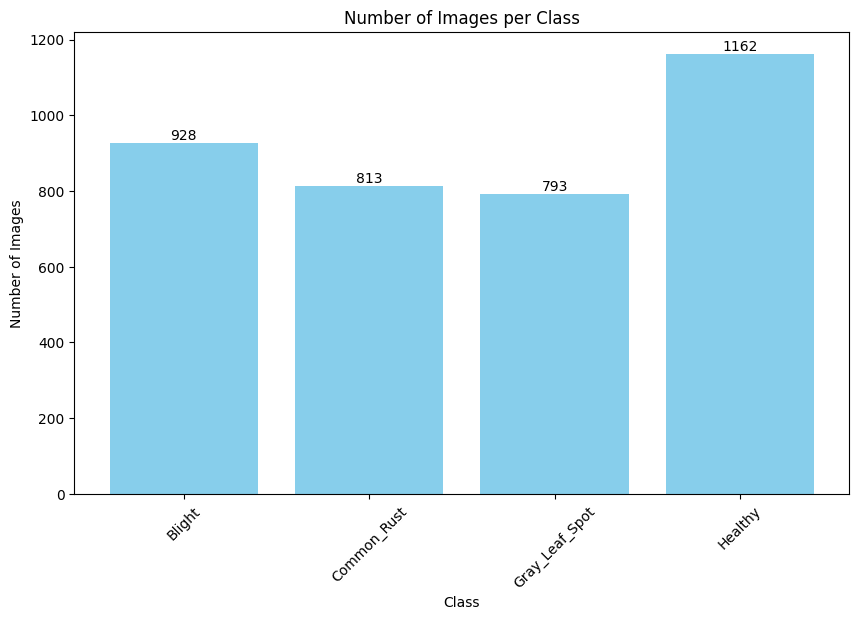

In [11]:
class_names = os.listdir(data_path)
class_counts = []

# Count the number of images in each class
for class_name in class_names:
    class_folder = os.path.join(data_path, class_name)
    num_images = len(os.listdir(class_folder))
    class_counts.append(num_images)

# Plotting the results
plt.figure(figsize=(10, 6))
bars=plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=10)

plt.show()

### Data Augmentation
Menambahkan ragam dan variasi gambar dari semua class yang ada.

In [19]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Showing Sample Augmentation Data
Menampilkan contoh data yang sudah dilakukan augmentasi.

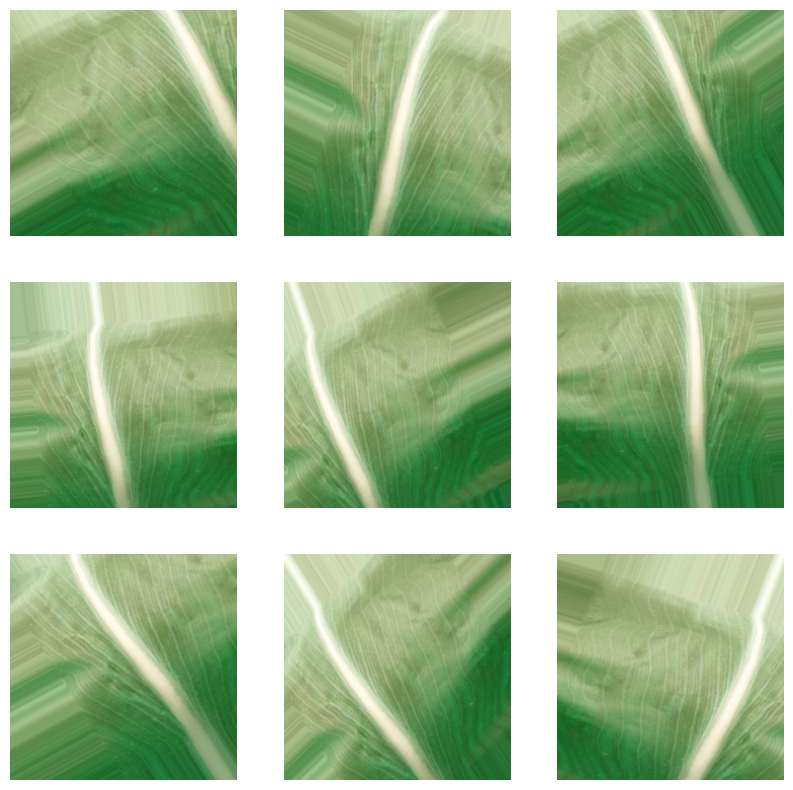

In [20]:
# Display a sample of augmented images
sample_image = X_train[0]  # take the first image in the training set
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_img = datagen.random_transform(sample_image)
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_img)
    plt.axis('off')
plt.show()


## Modelling
Model yang digunakan untuk project ini adalah CNN(Convolutional Neural Network), karena pada project ini akan melakukan classification images untuk mendeteksi penyakit jagung berdasarkan foto daunnya, sehingga model CNN adalah model yang sangat cocok untuk digunakan dalam project ini.

### Label Encoding
Mengubah label kategoris menjadi format numerik.

In [21]:
# Encode labels into numerical format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

### One Hot Encoding
Mengubah label format numerik menjadi format vektor biner, yang diperlukan untuk klasifikasi multikelas.

In [22]:
# Convert encoded labels to categorical format (one-hot encoding)
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

### Build Model
Membangun arsitektur model CNN

In [23]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(y_train_encoded.shape[1], activation='softmax')  # Output layer with number of classes
])

c:\Users\diima\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Compilation
Compile model dengan mendefinisikan optimizer, loss, dan evaluation.

In [24]:
# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Early Stopping
Menerapkan early stopping untuk mencegah overfitting.

In [25]:
# Set early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Augmentation for training
Buat data generator untuk training set untuk melakukan penambahan data secara selama pelatihan model.

In [26]:
# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Train Generator
Siapkan train generator data, tentukan batch size.

In [27]:
train_generator = train_datagen.flow(X_train, y_train_encoded, batch_size=16)

### Train the Model
Latih model menggunakan augmented training dataset dengan mendefinisikan epochs.

In [28]:
# Train the model
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=(X_test, y_test_encoded),
                    callbacks=[early_stopping])

c:\Users\diima\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.3512 - loss: 1.2852 - val_accuracy: 0.7405 - val_loss: 0.5549
Epoch 2/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.7194 - loss: 0.6128 - val_accuracy: 0.7568 - val_loss: 0.5157
Epoch 3/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.7179 - loss: 0.6049 - val_accuracy: 0.7743 - val_loss: 0.4828
Epoch 4/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.7437 - loss: 0.5125 - val_accuracy: 0.7905 - val_loss: 0.4804
Epoch 5/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.7701 - loss: 0.4858 - val_accuracy: 0.8014 - val_loss: 0.4295
Epoch 6/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.7676 - loss: 0.4914 - val_accuracy: 0.8324 - val_loss: 0.4081
Epoch 7/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.7849 - loss: 0.4435 - val_accuracy: 0.7703 - val_loss: 0.4084
Epoch 8/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.7797 - loss: 0.4628 - val_accu

### Model Evaluation
Mengevaluasi performa model.

In [29]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 471ms/step - accuracy: 0.9440 - loss: 0.1672
Test accuracy: 95.00%


### Visualize Model Evaluation
memvisualisasikan model evaluation menggunakan accuracy & loss, confusion matrix, dan classification report.

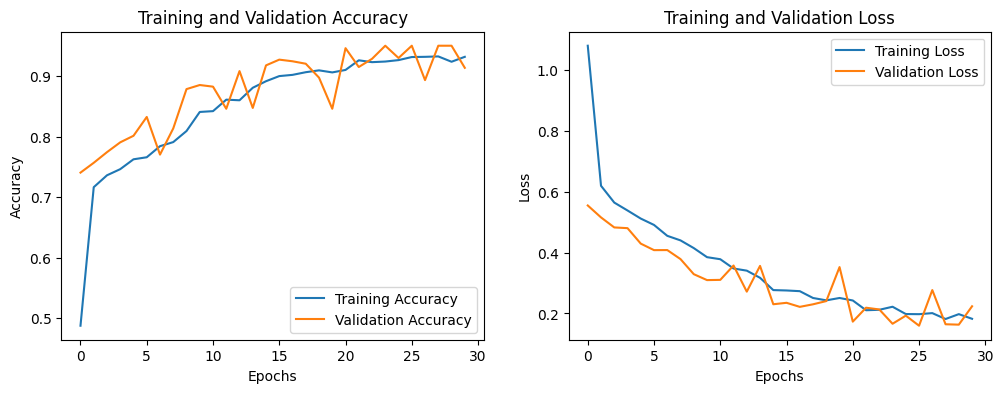

24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 518ms/step


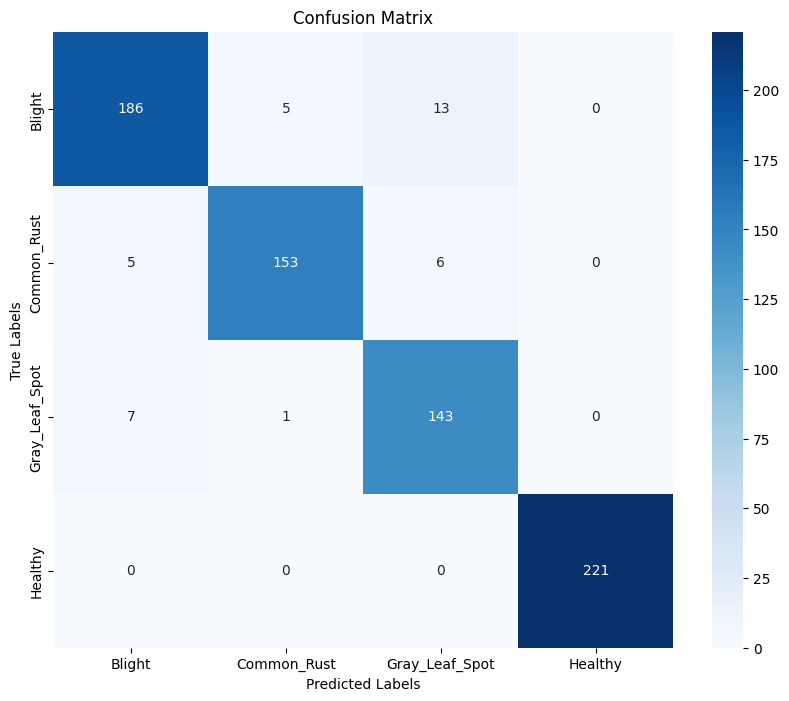

Classification Report:
                 precision    recall  f1-score   support

        Blight       0.94      0.91      0.93       204
   Common_Rust       0.96      0.93      0.95       164
Gray_Leaf_Spot       0.88      0.95      0.91       151
       Healthy       1.00      1.00      1.00       221

      accuracy                           0.95       740
     macro avg       0.95      0.95      0.95       740
  weighted avg       0.95      0.95      0.95       740



In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# 1. Plot Training and Validation Accuracy/Loss
history_dict = history.history

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 2. Confusion Matrix
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 3. Classification Report
# Print precision, recall, and F1-score
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


### Model Saving
Menyimpan model yang sudah selesai ditraining untuk digunakan saat testing menggunakan images.

In [32]:
model.save('model.h5')